In [1]:
import pandas as pd
import numpy as np
import dateparser
import matplotlib.pyplot as plt

In [2]:
# Charger le dataset (remplacez 'votre_fichier.csv' par le chemin réel du fichier)
df = pd.read_csv(r'C:\v_librairie\pwp\prediction_apple\moduleweb\dataset\cours_apple_5.csv')

# Étape 1 : Nettoyer et convertir la colonne des dates
# Conversion des dates avec 'dateparser' pour prendre en charge les noms de mois français
df['Date'] = df['Date'].apply(lambda x: dateparser.parse(x))

# Conversion explicite au format datetime (optionnel si 'dateparser' suffit)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Étape 2 : Nettoyer et convertir les colonnes numériques
# Liste des colonnes contenant des valeurs numériques
cols_to_convert = ['Ouverture','Plus Haut','Plus Bas','Ferme','Clôture Ajustée','Volume']

for col in cols_to_convert:
    df[col] = df[col].str.replace('\u202f', '')  # Supprimer les espaces insécables
    df[col] = df[col].str.replace(',', '.')     # Remplacer les virgules par des points
    df[col] = df[col].astype(float)             # Convertir en type float

# Étape 3 : Définir la colonne 'Date' comme index
df.set_index('Date', inplace=True)

# Vérifier le résultat
print(df.head())


            Ouverture  Plus Haut  Plus Bas   Ferme  Clôture Ajustée  \
Date                                                                  
2024-11-21     228.79     230.15    225.71  228.52           228.52   
2024-11-20     228.06     229.93    225.89  229.00           229.00   
2024-11-19     226.98     230.16    226.66  228.28           228.28   
2024-11-18     225.25     229.74    225.17  228.02           228.02   
2024-11-15     226.40     226.92    224.27  225.00           225.00   

                Volume  
Date                    
2024-11-21  40355157.0  
2024-11-20  35169600.0  
2024-11-19  36211800.0  
2024-11-18  44686000.0  
2024-11-15  47923700.0  


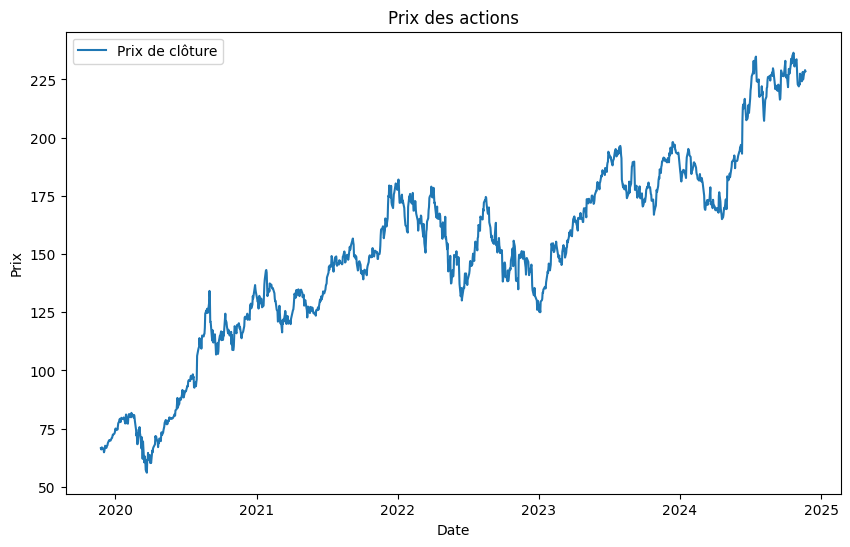

In [3]:
# Visualisation du prix de clôture
plt.figure(figsize=(10, 6))
plt.plot(df['Ferme'], label='Prix de clôture')
plt.title("Prix des actions")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Ferme']])

# Création des séquences
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

sequence_length = 120
X, Y = create_sequences(scaled_data, sequence_length)

# Division des données en ensembles d'entraînement et de test
split = int(0.8 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l1_l2

# Création du modèle LSTM
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(200,activation ="relu", return_sequences=True),
    Dropout(0.3),
    LSTM(200, activation="relu", return_sequences=False),
    Dense(25,activation ="relu"),
    Dense(1,activation ="tanh")
])

# Compilation du modèle
model.compile(optimizer='adam', loss=Huber())

# Entraînement
history = model.fit(X_train, Y_train, epochs=30, batch_size=64, validation_data=(X_test, Y_test))


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


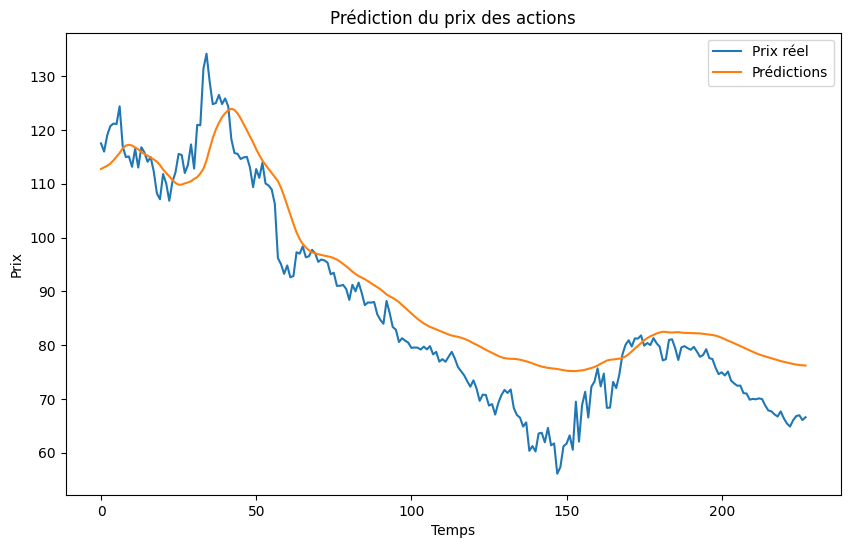

In [26]:
# Prédiction sur les données de test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Revenir à l'échelle originale

# Revenir à l'échelle originale pour Y_test
Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(Y_test_original, label="Prix réel")
plt.plot(predictions, label="Prédictions")
plt.title("Prédiction du prix des actions")
plt.xlabel("Temps")
plt.ylabel("Prix")
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


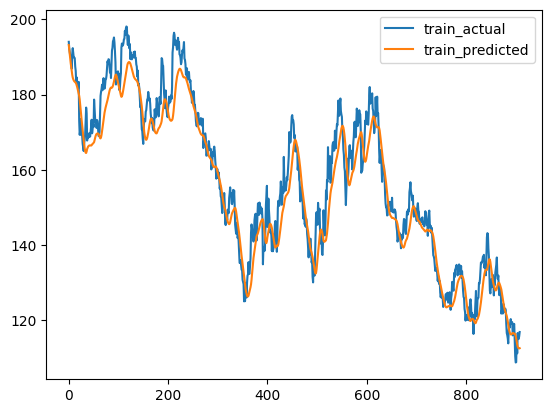

In [27]:
train_predicted = model.predict(X_train)
train_predicted = scaler.inverse_transform(train_predicted.reshape(-1, 1))

train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

x1 = np.arange(0, len(train_actual))
x2 = np.arange(len(train_actual), len(train_actual)+len(test_actual))

plt.plot(x1,train_actual)
plt.plot(x1,train_predicted)
plt.legend(['train_actual','train_predicted'])

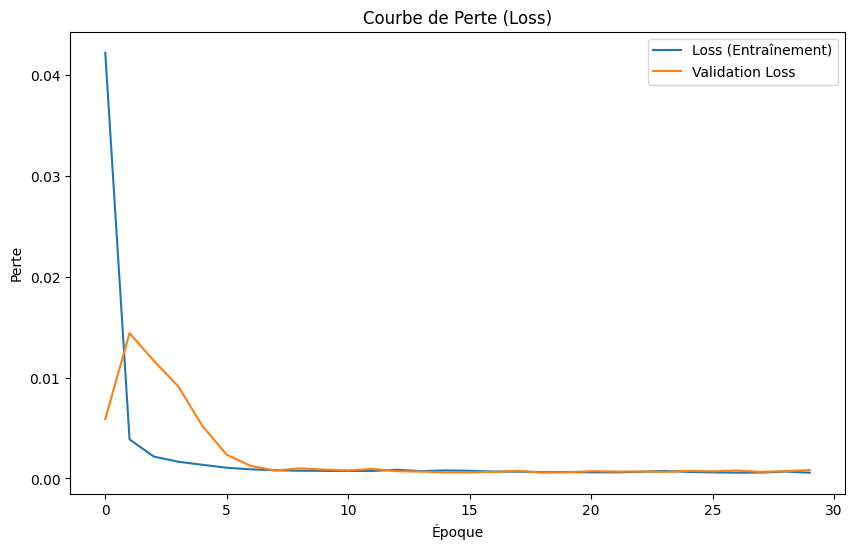

In [28]:
# Visualisation des courbes d'entraînement
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Perte (Loss)')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()

In [29]:
model.save("./prediction.h5")

In [21]:
import pandas as pd
import numpy as np
import dateparser
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Charger le dataset
df = pd.read_csv(r'C:\v_librairie\pwp\prediction_apple\moduleweb\dataset\cours_apple_5.csv')

# Fonction pour nettoyer et convertir les colonnes contenant des valeurs numériques
def clean_and_convert_column(col):
    col = col.str.replace('\u202f', '')  # Supprimer les espaces insécables
    col = col.str.replace(',', '.')      # Remplacer les virgules par des points
    return col.astype(float)             # Convertir en type float

# Nettoyer les colonnes numériques
numeric_cols = ['Ouverture', 'Plus Haut', 'Plus Bas', 'Ferme', 'Clôture Ajustée', 'Volume']
for col in numeric_cols:
    df[col] = clean_and_convert_column(df[col])

# Conversion de la colonne 'Date' en datetime
df['Date'] = df['Date'].apply(lambda x: dateparser.parse(x))
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Définir la colonne 'Date' comme index
df.set_index('Date', inplace=True)

# Normalisation des données (exemple avec la colonne 'Ferme')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Ferme']])

# Paramètres
sequence_length = 120

# Fonction pour créer des séquences
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

# Créer les séquences
X, Y = create_sequences(scaled_data, sequence_length)

# Charger votre modèle sauvegardé (si vous en avez un)
model = load_model(r'C:\v_librairie\pwp\prediction_apple\model\prediction.h5')

# Fonction pour prédire les prix futurs (itératif)
def predict_future_prices(n_days):
    # Initialiser la séquence avec les dernières données disponibles
    last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    
    predictions = []
    
    for _ in range(n_days):
        # Prédire la valeur pour le jour suivant
        predicted_price_scaled = model.predict(last_sequence)
        
        # Revenir à l'échelle originale
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))
        predictions.append(predicted_price[0][0])
        
        # Mettre à jour la séquence en ajoutant la valeur prédite et en supprimant la plus ancienne
        last_sequence = np.append(last_sequence[:, 1:, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)
    
    return predictions

# Exemple d'utilisation
n_days = 10  # Nombre de jours pour lesquels vous souhaitez prédire les prix
predicted_prices = predict_future_prices(n_days)

# Afficher les prédictions
print("Prix prédits pour les", n_days, "prochains jours:")
for i, price in enumerate(predicted_prices, 1):
    print(f"Jour {i}: {price}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Prix prédits pour les 10 prochains jours:
Jour 1: 76.16378021240234
Jour 2: 76.3390884399414
Jour 3: 76.64423370361328
Jour 4: 77.02369689941406
Jour 5: 77.44281005859375
Jour 6: 77.87931060791016
Jour 7: 78.31916809082031
Jour 8: 78.7540512084961
Jour 9: 79.178955078125
Jour 10: 79.59091186523438


In [ ]:
MODEL_PATH = 'model/prediction.h5'